### IMPORTS

In [1]:
from Inference import BBVI 
import numpy as np

In [2]:
import torch
import matplotlib.pyplot as plt
import _pickle as pickle

### EXAMPLE

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [4]:
# load data
data = torch.load('C:\\Users\\cortax\\Documents\\BayesianNN\\data\\foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [8]:
Net = BBVI.VariationalNetwork(input_size=1, output_size=1, layer_width=25, nb_layers=3, device=device)
Net.make_deterministic_rhos()
Net.requires_grad_rhos(False)

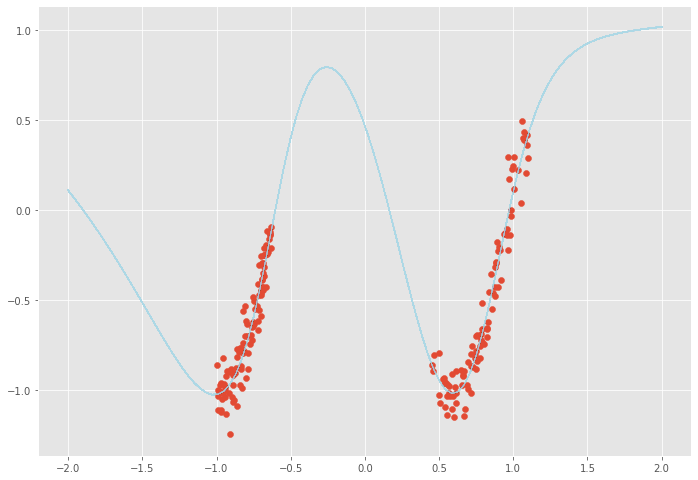

In [11]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    Net.sample_parameters()

    y_test = Net.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue') 

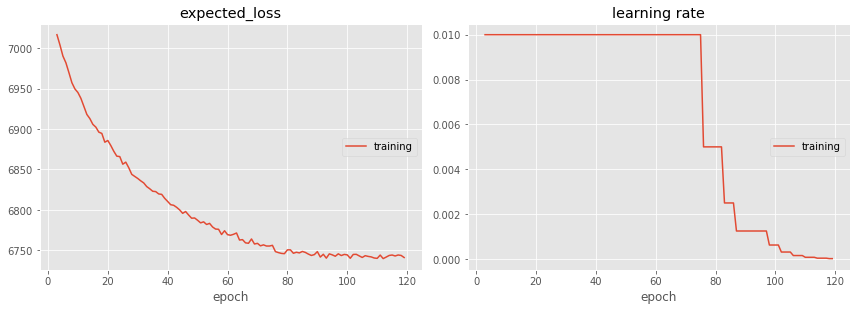

expected_loss:
training   (min: 6739.735, max: 9632.908, cur: 6741.066)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


KeyboardInterrupt: 

In [10]:
# Optimizing the Neural Network to get a Maximum A Posteriori (MAP) estimate
optimizer = torch.optim.Adam
optimizer_params = {'lr': 0.01}
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau
scheduler_params = {'patience': 3, 'factor': 0.5}

voptimizer = BBVI.VariationalOptimizer(model=Net, sigma_noise=0.1, optimizer=optimizer, optimizer_params=optimizer_params, scheduler=scheduler, scheduler_params=scheduler_params, min_lr=0.00001)
Net = voptimizer.run((x_data,y_data), n_epoch=1000, n_iter=100, n_ELBO_samples=1, plot=True)

In [29]:
model = Net
sigma_proposal = 0.001
nb_iter = 10000
plot = 1

In [30]:
netparam = model.get_network()
current_model =  BBVI.VariationalNetwork(input_size=netparam['input_size'],
                      output_size=netparam['output_size'],
                      layer_width=netparam['layer_width'],
                      nb_layers=netparam['nb_layers'])
current_model.set_network(netparam)
current_model.make_deterministic_rhos()

In [31]:
acceptance = []
samples = []
proba = []   

In [32]:
from livelossplot import PlotLosses


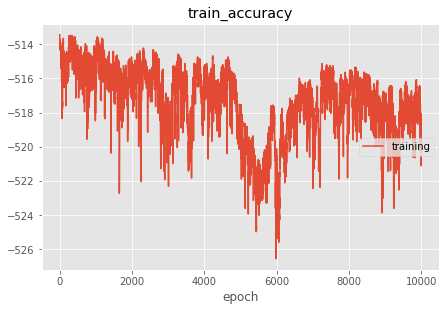

train_accuracy:
training   (min: -526.563, max: -513.265, cur: -520.554)


In [33]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(nb_iter):
    #proposal 
    netparam = current_model.get_network()
    proposed_model = BBVI.VariationalNetwork(input_size=netparam['input_size'],
                          output_size=netparam['output_size'],
                          layer_width=netparam['layer_width'],
                          nb_layers=netparam['nb_layers'])
    proposed_model.set_network(netparam)

    with torch.no_grad():
        for layer in proposed_model.registered_layers:
            epsilon = torch.empty(layer.q_weight_mu.size()).normal_(mean=0, std=sigma_proposal)
            layer.q_weight_mu.add_(epsilon)

            epsilon = torch.empty(layer.q_bias_mu.size()).normal_(mean=0, std=sigma_proposal)
            layer.q_bias_mu.add_(epsilon)

    #proba
    with torch.no_grad():
        layered_w_samples = []
        layered_bias_samples = []
        L = [(current_model.registered_layers[k].q_weight_mu.unsqueeze(0), current_model.registered_layers[k].q_bias_mu.unsqueeze(0)) for k in range(len(current_model.registered_layers))]
        for k in range(len(current_model.registered_layers)):
            if L[k] is not None:
                layered_w_samples.append(L[k][0])
                layered_bias_samples.append(L[k][1])
        log_prior_current = current_model.prior_log_pdf(layered_w_samples, layered_bias_samples)

        for layer in current_model.registered_layers:
            layer.weight_sample = layer.q_weight_mu.unsqueeze(0).detach().clone()
            layer.bias_sample = layer.q_bias_mu.unsqueeze(0).detach().clone()
        y_pred = current_model.forward(x_data)
        log_likelihood_current = current_model._log_norm(y_pred[0], y_data, torch.tensor(0.1)).sum()

        layered_w_samples = []
        layered_bias_samples = []
        L = [(proposed_model.registered_layers[k].q_weight_mu.unsqueeze(0), proposed_model.registered_layers[k].q_bias_mu.unsqueeze(0)) for k in range(len(proposed_model.registered_layers))]
        for k in range(len(proposed_model.registered_layers)):
            if L[k] is not None:
                layered_w_samples.append(L[k][0])
                layered_bias_samples.append(L[k][1])
        log_prior_proposal = proposed_model.prior_log_pdf(layered_w_samples, layered_bias_samples)

        for layer in proposed_model.registered_layers:
            layer.weight_sample = layer.q_weight_mu.unsqueeze(0).detach().clone()
            layer.bias_sample = layer.q_bias_mu.unsqueeze(0).detach().clone()
        y_pred = proposed_model.forward(x_data)
        log_likelihood_proposal = proposed_model._log_norm(y_pred[0], y_data, torch.tensor(0.1)).sum()

    with torch.no_grad():
        A = (log_likelihood_proposal + log_prior_proposal) - (log_likelihood_current + log_prior_current)
    
    logs = {}
    if torch.distributions.uniform.Uniform(0.0,1.0).sample().log() < A.cpu():
        acceptance.append(1)
        proba.append(log_likelihood_proposal + log_prior_proposal) 
        logs['train_accuracy'] = (log_likelihood_proposal + log_prior_proposal).detach().clone().cpu().numpy()[0]

        netparam = proposed_model.get_network()
        samples.append(netparam)
        current_model.set_network(netparam)

    else:
        acceptance.append(0)
        proba.append(log_likelihood_current + log_prior_current)
        logs['train_accuracy'] = (log_likelihood_current + log_prior_current).detach().clone().cpu().numpy()[0]

        netparam = current_model.get_network()
        samples.append(netparam)

    if plot:
        liveloss.update(logs)
        liveloss.draw()

In [34]:
np.mean(acceptance)

0.6979

In [35]:
netparam = Net.get_network()
model =  BBVI.VariationalNetwork(input_size=netparam['input_size'],
                      output_size=netparam['output_size'],
                      layer_width=netparam['layer_width'],
                      nb_layers=netparam['nb_layers'])

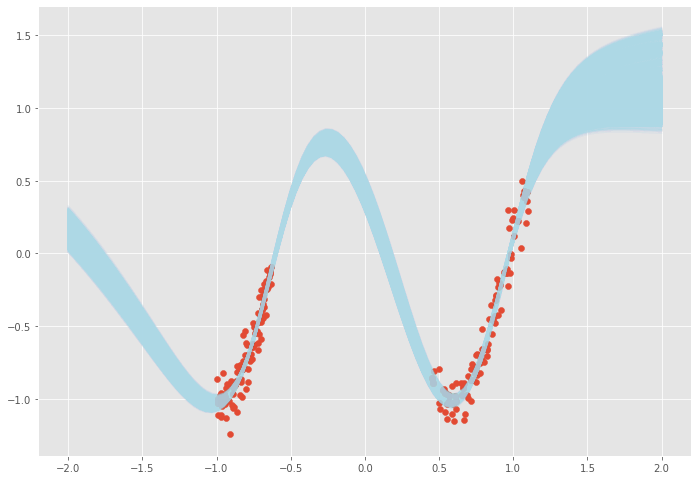

In [36]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.scatter(x_data.cpu(), y_data.cpu())
for j in range(len(samples)):
    model.set_network(samples[j])
    for layer in model.registered_layers:
        layer.weight_sample = layer.q_weight_mu.unsqueeze(0).detach().clone()
        layer.bias_sample = layer.q_bias_mu.unsqueeze(0).detach().clone()

    y_test = model.forward(x_test)
    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')